In [5]:
# Core data processing libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Text processing libraries
import re
import string
from collections import Counter

# Language detection
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Emoji processing
import emoji

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
plt.style.use('default')
%matplotlib inline

# Utility libraries
import os
import time
from datetime import datetime
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [6]:
# Load data
data_path = r'c:\Users\user\OneDrive\Documents\LOREALREAL HACKATHON\dataset' 
comment_files = [f'comments{i}.csv' for i in range(1, 6)]
video_file = 'videos.csv'

# Load all comment files
all_comments = []
for i, file in enumerate(comment_files, 1):
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path, low_memory=False, dtype=str)
    all_comments.append(df)

# Combine all comments
comments_df = pd.concat(all_comments, ignore_index=True)

# Load video data
try:
    videos_df = pd.read_csv(os.path.join(data_path, video_file))
except Exception as e:
    videos_df = None

print(f"Loaded {len(comments_df):,} comments from {len(comment_files)} files")
if videos_df is not None:
    print(f"Loaded {len(videos_df):,} videos")

Loaded 4,725,012 comments from 5 files
Loaded 92,759 videos


In [7]:
def clean_text(text):
    """Clean text while preserving meaningful content."""
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[!]{4,}', '!!!', text)
    text = re.sub(r'[?]{4,}', '???', text)
    text = re.sub(r'[.]{4,}', '...', text)
    text = text.strip()
    
    return text

def detect_language_safe(text, confidence_threshold=0.8):
    """Safely detect language with confidence scoring."""
    try:
        if len(str(text).strip()) < 3:
            return 'unknown'
        text_no_emoji = emoji.demojize(str(text))
        detected_lang = detect(text_no_emoji)
        return detected_lang
    except:
        return 'unknown'

def calculate_text_stats(text):
    """Calculate comprehensive text statistics for spam detection."""
    text = str(text)
    
    char_count = len(text)
    word_count = len(text.split())
    avg_word_length = np.mean([len(word) for word in text.split()]) if word_count > 0 else 0
    
    upper_count = sum(1 for c in text if c.isupper())
    caps_ratio = upper_count / max(char_count, 1)
    
    special_chars = sum(1 for c in text if c in string.punctuation)
    special_ratio = special_chars / max(char_count, 1)
    
    url_count = len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))
    
    words = text.lower().split()
    word_freq = Counter(words)
    max_word_freq = max(word_freq.values()) if words else 0
    repetition_ratio = max_word_freq / max(word_count, 1)
    
    return {
        'char_count': char_count,
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'caps_ratio': caps_ratio,
        'special_ratio': special_ratio,
        'url_count': url_count,
        'repetition_ratio': repetition_ratio,
        'has_url': 1 if url_count > 0 else 0
    }

def extract_emoji_features(text):
    """Extract comprehensive emoji features for spam detection."""
    text = str(text)
    
    emojis = emoji.emoji_list(text)
    emoji_chars = [item['emoji'] for item in emojis]
    
    emoji_count = len(emoji_chars)
    unique_emojis = len(set(emoji_chars))
    text_length = len(text)
    
    emoji_ratio = emoji_count / max(text_length, 1)
    emoji_diversity = unique_emojis / max(emoji_count, 1)
    
    positive_emojis = ['😍', '💕', '❤️', '✨', '🌟', '😊', '👍', '🔥', '💯', '🥰', '😘',
                       '🤩', '😎', '🥳', '🤗', '😇', '🙌', '👏', '💪', '🎉', '🙏', '☺️', 
                       '😀', '😁', '😂', '🤣', '😃', '😄', '😆', '🥲', '💖', '💗', '💝']
    
    negative_emojis = ['😒', '😕', '👎', '😞', '😠', '😡', '💔', '😢', '😭', '🙄', 
                       '😤', '😩', '🤮', '🤢', '😵', '🥺', '😖', '😓', '😰', '😨',
                       '😱', '🤬', '😈', '💀', '😷', '🤒', '🤕']
    
    positive_count = sum([emoji_chars.count(e) for e in positive_emojis])
    negative_count = sum([emoji_chars.count(e) for e in negative_emojis])
    
    known_emojis = set(positive_emojis + negative_emojis)
    unknown_emoji_count = len([e for e in emoji_chars if e not in known_emojis])
    
    music_emojis = ['🎵', '🎤', '🎸', '🎼', '🎶', '🎧', '🎹', '🥁', '🎺', '🎻']
    food_emojis = ['🍕', '🍔', '🥗', '🍰', '🍜', '🍎', '🍌', '🥑', '🍓', '🍉', '🧁']
    beauty_emojis = ['💄', '💋', '👄', '💅', '🧴', '🪞', '✨', '💎', '👗', '👠']
    
    music_count = sum([emoji_chars.count(e) for e in music_emojis])
    food_count = sum([emoji_chars.count(e) for e in food_emojis])
    beauty_count = sum([emoji_chars.count(e) for e in beauty_emojis])
    
    sentiment_score = positive_count - negative_count + (unknown_emoji_count * 0.1)
    
    return {
        'emoji_count': emoji_count,
        'emoji_ratio': emoji_ratio,
        'emoji_diversity': emoji_diversity,
        'positive_emoji_count': positive_count,
        'negative_emoji_count': negative_count,
        'unknown_emoji_count': unknown_emoji_count,
        'emoji_sentiment_score': sentiment_score,
        'music_emoji_count': music_count,
        'food_emoji_count': food_count,
        'beauty_emoji_count': beauty_count,
        'spam_emoji_indicator': 1 if emoji_ratio > 0.3 and emoji_diversity < 0.5 else 0
    }

In [8]:
def create_feature_pipeline(comments_df, videos_df=None):
    """Feature engineering pipeline for spam detection."""
    
    start_time = time.time()
    features_df = comments_df.copy()
    
    # 1. Text processing
    features_df['cleaned_text'] = features_df['textOriginal'].apply(clean_text)
    
    text_stats = features_df['cleaned_text'].apply(calculate_text_stats)
    text_stats_df = pd.DataFrame(text_stats.tolist())
    features_df = pd.concat([features_df, text_stats_df], axis=1)
    
    # 2. Emoji analysis
    emoji_features = features_df['textOriginal'].apply(extract_emoji_features)
    emoji_features_df = pd.DataFrame(emoji_features.tolist())
    features_df = pd.concat([features_df, emoji_features_df], axis=1)
    
    # 3. Engagement features
    features_df['likeCount'] = pd.to_numeric(features_df['likeCount'], errors='coerce').fillna(0)
    features_df['likes_per_char'] = features_df['likeCount'] / (features_df['char_count'] + 1)
    features_df['is_reply'] = (~features_df['parentCommentId'].isna()).astype(int)
    
    # 4. Temporal patterns
    features_df['publishedAt'] = pd.to_datetime(features_df['publishedAt'], errors='coerce')
    features_df['hour_of_day'] = features_df['publishedAt'].dt.hour
    features_df['day_of_week'] = features_df['publishedAt'].dt.dayofweek
    
    # 5. Spam behavior detection
    generic_patterns = [
        r'^(first|1st)!?$',
        r'^(nice|good|great|awesome|amazing|cool)!*$',
        r'^(love it|love this|loved it)!*$',
        r'^(thanks|thank you)!*$',
        r'^(wow|omg|lol|haha)!*$'
    ]
    
    features_df['is_generic'] = 0
    for pattern in generic_patterns:
        mask = features_df['cleaned_text'].str.lower().str.match(pattern, na=False)
        features_df.loc[mask, 'is_generic'] = 1
    
    features_df['suspicious_engagement'] = (
        (features_df['char_count'] < 10) & 
        (features_df['likeCount'] > 5)
    ).astype(int)
    
    features_df['excessive_caps'] = (features_df['caps_ratio'] > 0.5).astype(int)
    features_df['excessive_repetition'] = (features_df['repetition_ratio'] > 0.7).astype(int)
    
    # 6. Quality indicators
    features_df['sufficient_length'] = (features_df['char_count'] >= 10).astype(int)
    features_df['balanced_punctuation'] = (
        (features_df['special_ratio'] > 0.01) & 
        (features_df['special_ratio'] < 0.3)
    ).astype(int)
    
    features_df['meaningful_emoji_usage'] = (
        (features_df['emoji_count'] > 0) & 
        (features_df['emoji_ratio'] < 0.3) & 
        (features_df['emoji_diversity'] > 0.5)
    ).astype(int)
    
    features_df['authentic_engagement'] = (
        (features_df['char_count'] >= 15) &
        (features_df['caps_ratio'] < 0.4) &
        (features_df['repetition_ratio'] < 0.5) &
        (features_df['special_ratio'] < 0.25)
    ).astype(int)
    
    # 7. Feature selection (Top 20)
    base_features = [
        'kind', 'commentId', 'channelId', 'videoId', 'authorId', 
        'textOriginal', 'parentCommentId', 'likeCount', 'publishedAt', 'updatedAt'
    ]
    
    engineered_features = [
        'char_count', 'word_count', 'caps_ratio', 'repetition_ratio', 
        'emoji_ratio', 'emoji_diversity', 'likes_per_char', 'is_reply', 
        'url_count', 'is_generic'
    ]
    
    feature_columns = base_features + engineered_features
    
    for col in engineered_features:
        if col in features_df.columns:
            features_df[col] = features_df[col].fillna(0)
    
    available_features = [col for col in feature_columns if col in features_df.columns]
    ml_features = [col for col in engineered_features if col in features_df.columns]
    X = features_df[ml_features].copy()
    
    total_time = time.time() - start_time
    print(f"Feature engineering completed in {total_time:.2f} seconds")
    print(f"Generated {len(ml_features)} ML features from {len(features_df):,} comments")
    
    return {
        'features': X,
        'full_data': features_df[available_features],
        'text': features_df['cleaned_text'],
        'original_data': features_df,
        'feature_names': ml_features,
        'all_feature_names': available_features
    }

In [9]:
# Process full dataset through feature engineering pipeline
processed_data = create_feature_pipeline(comments_df, videos_df)

# Extract results
X_features = processed_data['features']
text_data = processed_data['text']
feature_names = processed_data['feature_names']

print(f"Feature matrix shape: {X_features.shape}")
print(f"Feature names: {feature_names}")

# Data quality check
missing_values = X_features.isnull().sum().sum()
infinite_values = np.isinf(X_features).sum().sum()

if missing_values > 0:
    print(f"Warning: {missing_values} missing values found")
if infinite_values > 0:
    print(f"Warning: {infinite_values} infinite values found")

Feature engineering completed in 381.49 seconds
Generated 10 ML features from 4,725,012 comments
Feature matrix shape: (4725012, 10)
Feature names: ['char_count', 'word_count', 'caps_ratio', 'repetition_ratio', 'emoji_ratio', 'emoji_diversity', 'likes_per_char', 'is_reply', 'url_count', 'is_generic']
Feature matrix shape: (4725012, 10)
Feature names: ['char_count', 'word_count', 'caps_ratio', 'repetition_ratio', 'emoji_ratio', 'emoji_diversity', 'likes_per_char', 'is_reply', 'url_count', 'is_generic']


In [10]:
def prepare_clustering_data(processed_data, scale_features=True):
    """Prepare data for GMM clustering."""
    
    X_features = processed_data['features']
    text_data = processed_data['text']
    original_data = processed_data['original_data']
    
    # Select top 10 ML features
    clustering_features = [
        'char_count', 'caps_ratio', 'repetition_ratio', 'emoji_ratio', 'emoji_diversity',
        'likes_per_char', 'is_reply', 'url_count', 'word_count', 'is_generic'
    ]
    
    available_features = [f for f in clustering_features if f in X_features.columns]
    X_clustering = X_features[available_features].copy()
    
    # Data quality checks
    missing_values = X_clustering.isnull().sum().sum()
    infinite_values = np.isinf(X_clustering).sum().sum()
    
    if missing_values > 0:
        X_clustering = X_clustering.fillna(0)
    
    if infinite_values > 0:
        X_clustering = X_clustering.replace([np.inf, -np.inf], [1e6, -1e6])
    
    # Feature scaling
    if scale_features:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_clustering)
        X_clustering_final = pd.DataFrame(X_scaled, columns=available_features, index=X_clustering.index)
    else:
        scaler = None
        X_clustering_final = X_clustering
    
    print(f"Prepared {len(X_clustering_final):,} comments with {len(available_features)} features")
    
    return {
        'X_clustering': X_clustering_final,
        'text_data': text_data,
        'original_data': original_data,
        'feature_names': available_features,
        'scaler': scaler,
        'data_stats': {
            'n_samples': len(X_clustering_final),
            'n_features': len(available_features),
            'missing_values': missing_values,
            'infinite_values': infinite_values
        }
    }

# Apply clustering data preparation
clustering_data = prepare_clustering_data(processed_data, scale_features=True)

# Extract clustering data
X_clustering = clustering_data['X_clustering']
text_data = clustering_data['text_data']
feature_names = clustering_data['feature_names']

# Define uncertainty thresholds
UNCERTAINTY_LOWER = 0.40
UNCERTAINTY_UPPER = 0.60

Prepared 4,725,012 comments with 10 features


In [11]:
# GMM Clustering (K=2: Spam vs Quality)
gmm_primary = GaussianMixture(
    n_components=2,
    covariance_type='full',
    init_params='kmeans',
    max_iter=200,
    n_init=10,
    random_state=42
)

# Fit clustering
start_time = time.time()
primary_labels = gmm_primary.fit_predict(X_clustering)
primary_probabilities = gmm_primary.predict_proba(X_clustering)
primary_time = time.time() - start_time

print(f"Clustering completed in {primary_time:.2f} seconds")

# Get maximum probabilities and predictions
max_probabilities = np.max(primary_probabilities, axis=1)
predicted_clusters = np.argmax(primary_probabilities, axis=1)

# Determine spam vs quality clusters
cluster_stats = {}
for cluster_id in [0, 1]:
    mask = primary_labels == cluster_id
    cluster_data = X_clustering[mask]
    
    stats = {
        'size': mask.sum(),
        'avg_char_count': cluster_data['char_count'].mean(),
        'generic_percentage': cluster_data['is_generic'].mean() * 100,
        'avg_caps_ratio': cluster_data['caps_ratio'].mean(),
    }
    cluster_stats[cluster_id] = stats

# Identify spam cluster
spam_score_0 = (cluster_stats[0]['generic_percentage'] + 
                cluster_stats[0]['avg_caps_ratio'] * 100 - 
                cluster_stats[0]['avg_char_count'] / 10)
spam_score_1 = (cluster_stats[1]['generic_percentage'] + 
                cluster_stats[1]['avg_caps_ratio'] * 100 - 
                cluster_stats[1]['avg_char_count'] / 10)

spam_cluster_id = 0 if spam_score_0 > spam_score_1 else 1

# Apply uncertainty handling
def assign_final_labels_with_uncertainty(probabilities, predicted_clusters, spam_cluster_id):
    max_probs = np.max(probabilities, axis=1)
    final_labels = []
    
    for i, (max_prob, cluster) in enumerate(zip(max_probs, predicted_clusters)):
        if max_prob > UNCERTAINTY_UPPER:
            final_labels.append('spam' if cluster == spam_cluster_id else 'quality')
        else:
            final_labels.append('uncertain')
    
    return np.array(final_labels)

final_labels = assign_final_labels_with_uncertainty(
    primary_probabilities, predicted_clusters, spam_cluster_id
)

# Calculate distribution
unique_final, counts_final = np.unique(final_labels, return_counts=True)
total_comments = len(final_labels)

print("\nFinal classification:")
for label, count in zip(unique_final, counts_final):
    percentage = count / total_comments * 100
    print(f"  {label.title()}: {count:,} ({percentage:.1f}%)")

# Store results
clustering_results = {
    'gmm_primary': gmm_primary,
    'primary_labels': primary_labels,
    'primary_probabilities': primary_probabilities,
    'final_labels': final_labels,
    'max_probabilities': max_probabilities,
    'spam_cluster_id': spam_cluster_id,
    'uncertainty_thresholds': {'lower': UNCERTAINTY_LOWER, 'upper': UNCERTAINTY_UPPER},
    'cluster_stats': cluster_stats,
    'metrics': {
        'uncertainty_rate': (final_labels == 'uncertain').mean(),
        'processing_time': primary_time,
        'total_comments': len(final_labels)
    }
}

Clustering completed in 553.93 seconds

Final classification:
  Quality: 4,388,220 (92.9%)
  Spam: 333,840 (7.1%)
  Uncertain: 2,952 (0.1%)

Final classification:
  Quality: 4,388,220 (92.9%)
  Spam: 333,840 (7.1%)
  Uncertain: 2,952 (0.1%)


In [12]:
# Save model
model_artifacts = {
    'gmm_model': gmm_primary,
    'scaler': clustering_data['scaler'],
    'feature_names': clustering_data['feature_names'],
    'spam_cluster_id': spam_cluster_id,
    'uncertainty_thresholds': {'lower': UNCERTAINTY_LOWER, 'upper': UNCERTAINTY_UPPER},
    'cluster_stats': cluster_stats,
    'metrics': clustering_results['metrics']
}

model_filename = 'comment_spam_detection_model.pkl'
joblib.dump(model_artifacts, model_filename)
print(f"Model saved: {model_filename}")

# Export CSV with top 20 features
complete_original_data = processed_data['full_data'].copy()
complete_original_data['spam_classification'] = final_labels
complete_original_data['classification_confidence'] = max_probabilities

output_filename = 'complete_comments_top20_features.csv'
complete_original_data.to_csv(output_filename, index=False, encoding='utf-8')

print(f"Dataset exported: {output_filename}")
print(f"Total rows: {len(complete_original_data):,}")
print(f"Features: 22 total (10 base + 10 engineered + 2 classification)")

Model saved: comment_spam_detection_model.pkl
Dataset exported: complete_comments_top20_features.csv
Total rows: 4,725,012
Features: 22 total (10 base + 10 engineered + 2 classification)
Dataset exported: complete_comments_top20_features.csv
Total rows: 4,725,012
Features: 22 total (10 base + 10 engineered + 2 classification)


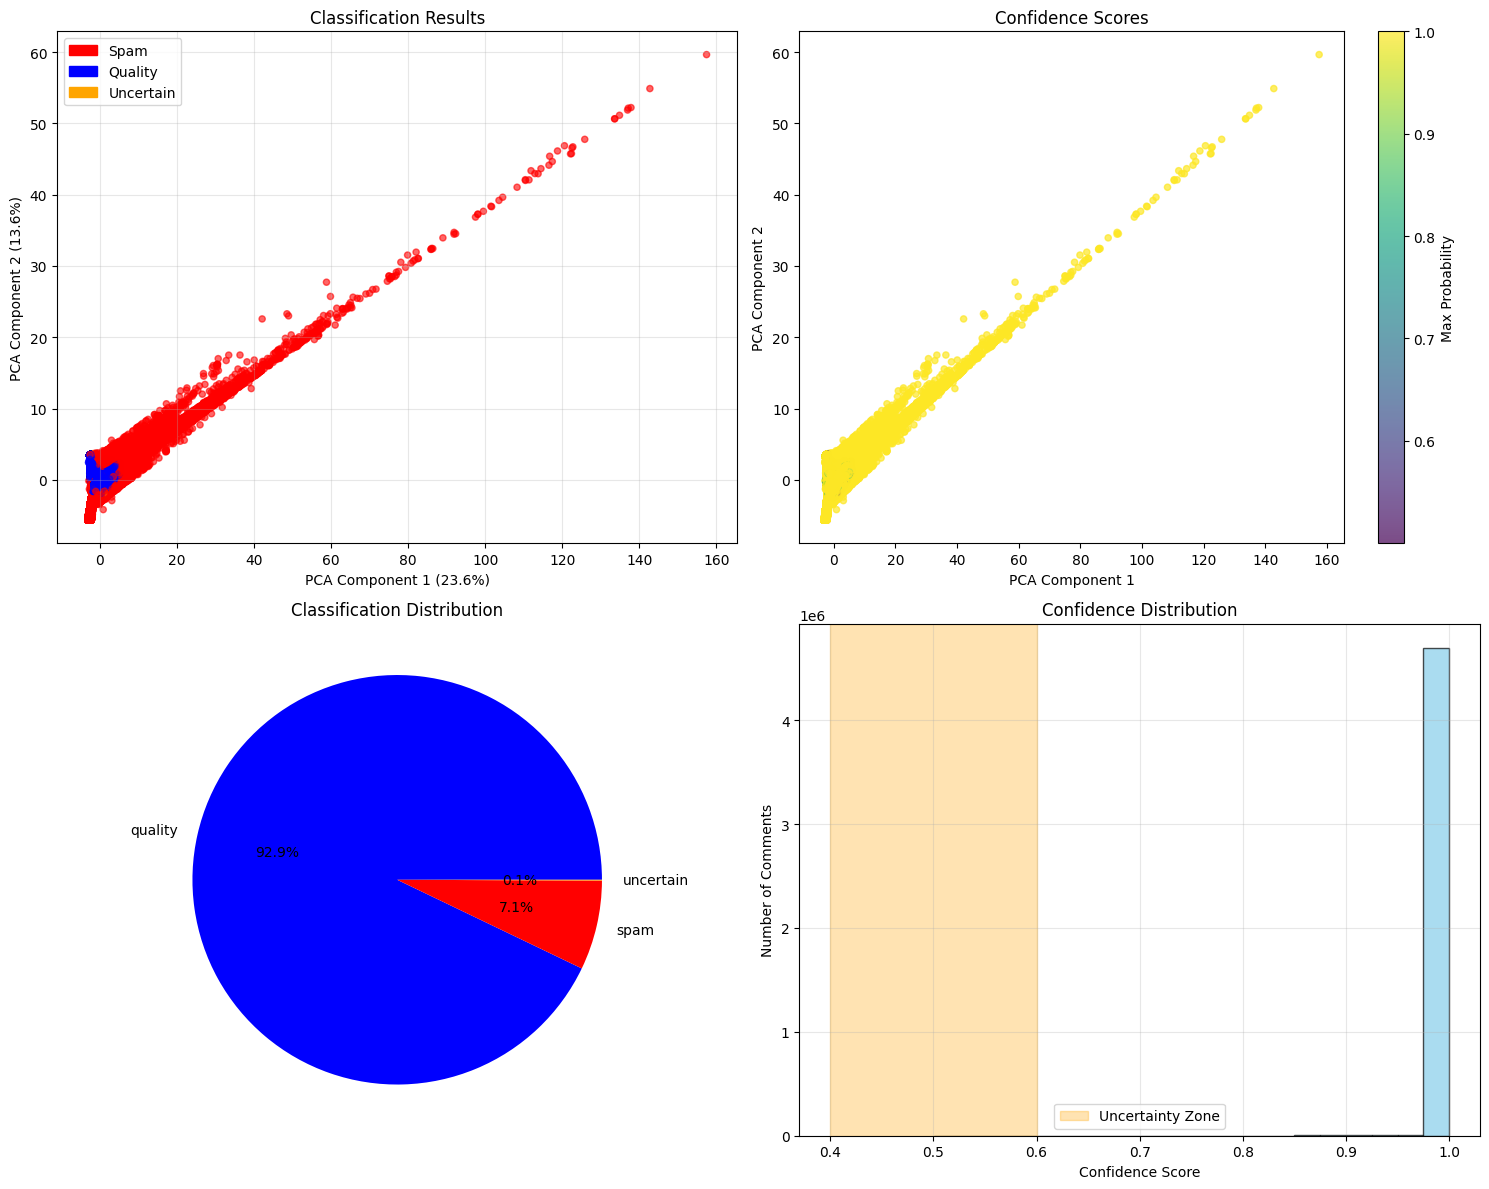

PCA explains 37.2% of total variance


In [13]:
# Visualize clustering results
X_clustering = clustering_data['X_clustering']
final_labels = clustering_results['final_labels']
max_probabilities = clustering_results['max_probabilities']
uncertainty_thresholds = clustering_results['uncertainty_thresholds']

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clustering)

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Classification scatter plot
color_map = {'spam': 'red', 'quality': 'blue', 'uncertain': 'orange'}
colors = [color_map[label] for label in final_labels]

axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, s=20)
axes[0, 0].set_xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0, 0].set_ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0, 0].set_title('Classification Results')
axes[0, 0].grid(True, alpha=0.3)

# Add legend
red_patch = mpatches.Patch(color='red', label='Spam')
blue_patch = mpatches.Patch(color='blue', label='Quality')
orange_patch = mpatches.Patch(color='orange', label='Uncertain')
axes[0, 0].legend(handles=[red_patch, blue_patch, orange_patch])

# Plot 2: Confidence scores
scatter = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=max_probabilities, 
                            cmap='viridis', alpha=0.7, s=20)
axes[0, 1].set_xlabel('PCA Component 1')
axes[0, 1].set_ylabel('PCA Component 2')
axes[0, 1].set_title('Confidence Scores')
plt.colorbar(scatter, ax=axes[0, 1], label='Max Probability')

# Plot 3: Label distribution
final_counts = pd.Series(final_labels).value_counts()
colors_pie = [color_map[label] for label in final_counts.index]
axes[1, 0].pie(final_counts.values, labels=final_counts.index, 
               autopct='%1.1f%%', colors=colors_pie)
axes[1, 0].set_title('Classification Distribution')

# Plot 4: Confidence histogram
axes[1, 1].hist(max_probabilities, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].axvspan(uncertainty_thresholds['lower'], uncertainty_thresholds['upper'], 
                   alpha=0.3, color='orange', label='Uncertainty Zone')
axes[1, 1].set_xlabel('Confidence Score')
axes[1, 1].set_ylabel('Number of Comments')
axes[1, 1].set_title('Confidence Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"PCA explains {pca.explained_variance_ratio_.sum():.1%} of total variance")

In [ ]:
# Final summary
spam_count = (final_labels == 'spam').sum()
quality_count = (final_labels == 'quality').sum()
uncertain_count = (final_labels == 'uncertain').sum()
total_comments = len(final_labels)

print("Final Results:")
print(f"  Spam: {spam_count:,} ({spam_count/total_comments*100:.1f}%)")
print(f"  Quality: {quality_count:,} ({quality_count/total_comments*100:.1f}%)")
print(f"  Uncertain: {uncertain_count:,} ({uncertain_count/total_comments*100:.1f}%)")

# Model performance
metrics = clustering_results['metrics']
print(f"\nPerformance:")
print(f"  Processing time: {metrics['processing_time']:.2f} seconds")
print(f"  Uncertainty rate: {metrics['uncertainty_rate']*100:.1f}%")

if uncertain_count > 0:
    uncertain_probs = max_probabilities[final_labels == 'uncertain']
    print(f"  Avg uncertainty confidence: {uncertain_probs.mean():.3f}")

print(f"\nFiles already created:")
print(f"  Model: {model_filename}")
print(f"  Dataset: complete_comments_top20_features.csv")
print(f"  Features include: spam_classification & classification_confidence")

print(f"\nFinal dataset contains:")
print(f"  Spam comments: {spam_count:,}")
print(f"  Quality comments: {quality_count:,}")
print(f"  Uncertain comments: {uncertain_count:,}")

Final Results:
  Spam: 333,840 (7.1%)
  Quality: 4,388,220 (92.9%)
  Uncertain: 2,952 (0.1%)

Performance:
  Processing time: 553.93 seconds
  Uncertainty rate: 0.1%
  Avg uncertainty confidence: 0.554


AttributeError: 'numpy.ndarray' object has no attribute 'map'